<a href="https://colab.research.google.com/github/omararh/Expression-editor-assistant/blob/main/phi_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("La version de torch est : ", torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

La version de torch est :  2.6.0+cu124
Le calcul GPU est disponible ?  True


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "microsoft/Phi-3-mini-4k-instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
import json

def read_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    return json.load(f)

INPUT_DATA_BASE_PATH = 'input_data/'

AVAILABLE_CONTEXT = read_file(INPUT_DATA_BASE_PATH + 'context.json')

SYMFONY_EXAMPLES = read_file(INPUT_DATA_BASE_PATH + 'examples.json')

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
!python -m spacy download fr_core_news_md

# Load french tokenizer, tagger, parser
nlp = spacy.load('fr_core_news_md')

def get_embedding(text):
    """
    Get normalized average embedding of all tokens (filtered).
    """
    doc = nlp(text)
    vectors = np.array([token.vector for token in doc if token.has_vector and not token.is_stop and not token.is_punct])

    if len(vectors) == 0:
        return np.zeros((nlp.vocab.vectors_length,))

    avg_vector = np.mean(vectors, axis=0)
    return avg_vector / np.linalg.norm(avg_vector)


def select_relevant_examples(user_query, examples_dict, top_k=5):
    """
    Sélectionne les exemples les plus pertinents en fonction de la similarité
    d'embedding avec la requête utilisateur.

    Args:
        user_query: user request
        examples_dict: (description -> expression) examples
        top_k: K relevant examples to be returned

    Returns:
        K relevant examples
    """
    query_embedding = get_embedding(user_query)

    similarities = []

    for description, expression in examples_dict.items():
        desc_embedding = get_embedding(description)

        similarity = cosine_similarity([query_embedding], [desc_embedding])[0][0]
        similarities.append((similarity, description, expression))

    similarities.sort(reverse=True)
    top_examples = [(desc, expr) for _, desc, expr in similarities[:top_k]]

    return top_examples


In [19]:
def generate_expression(user_intent, available_context=None, examples=None, max_retries=1):
    """
    Génère une suggestion d'expression Symfony avec retry en cas d'échec
    Args:
        user_intent (str): Intention ou question de l'utilisateur
        available_context (dict, optional): Contexte disponible dans l'éditeur
        examples (list, optional): Exemples d'expressions valides
        max_retries (int, optional): Nombre maximal de tentatives en cas d'erreur
    Returns:
        str: Expression Symfony suggérée par le modèle
    """
    # Construction du prompt pour Phi-2
    prompt = _build_prompt(user_intent, available_context, examples)

    retries = 0
    while retries <= max_retries:
        try:
            # Génération et traitement de la réponse
            response = _generate_and_process_response(prompt)

            # Vérification que la réponse n'est pas vide
            if _is_valid_response(response):
                return response
            else:
                # Si réponse vide ou invalide, retenter
                retries = _handle_retry(retries, max_retries, "Réponse vide ou invalide")
        except Exception as e:
            # En cas d'erreur, retenter
            retries = _handle_retry(retries, max_retries, f"Erreur lors de la génération: {e}")

    # Si après toutes les tentatives, rien n'a fonctionné
    return "Une erreur est survenue, veuillez réessayer."


def _build_prompt(user_intent, available_context, examples):
    """Construit un prompt clair et minimaliste pour le modèle Phi-3"""

    prompt = (
        "Tu es un assistant expert en Symfony Expression Language. "
        "Ta tâche est de générer une **seule** expression Symfony valide, sans aucune explication, "
        "en te basant uniquement sur le contexte et les exemples fournis.\n\n"
    )

    # Contexte disponible
    if available_context:
        prompt += "Contexte :\n"
        for category, items in available_context.items():
            prompt += f"- {category} : {', '.join(items)}\n"
        prompt += "\n"

    # Exemples pertinents
    if examples:
        prompt += "Exemples :\n"
        inverted_examples = {v: k for k, v in examples.items()}
        relevant_examples = select_relevant_examples(user_intent, inverted_examples, top_k=3)
        for description, expression in relevant_examples:
            prompt += f"Demande : {description}\n"
            prompt += f"Expression : {expression}\n\n"

    # Ajout de l’intention actuelle de l’utilisateur
    prompt += f"Demande : {user_intent.strip()}\n"
    prompt += "Expression :"

    return prompt

def _generate_and_process_response(prompt):
    """Génère une réponse et extrait la partie pertinente"""
    # Encoder le prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Minimized parameters
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,         #
        do_sample=False,           #
        num_beams=1,               #
        top_p=None,                #
        eos_token_id=tokenizer.eos_token_id
    )

    # Décodage de la sortie
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraction de la partie pertinente
    return _extract_response(full_response, prompt)


def _extract_response(full_response, prompt):
    response = full_response.replace(prompt, "").strip()

    # Supprime les sections parasites si présentes
    for unwanted in ["###", "[", "]", "Contexte", "Réponse", "Explication", "Analyse"]:
        if unwanted.lower() in response.lower():
            response = response.split("\n")[0].strip()
            break

    # Extrait à partir de "Expression Symfony:" si possible
    if "Expression Symfony:" in full_response:
        response = full_response.split("Expression Symfony:")[-1].strip()

    # Nettoyage supplémentaire
    if "\n" in response:
        response = response.split("\n")[0].strip()

    return response

def _is_valid_response(response):
    """Vérifie si la réponse est valide"""
    return response and not response.isspace() and "```" not in response


def _handle_retry(retries, max_retries, error_message):
    """Gère la logique de retry et renvoie le nouveau compteur"""
    retries += 1
    print(f"{error_message}, tentative {retries}/{max_retries+1}...")

    # Attendre un peu avant de retenter
    import time
    time.sleep(1)

    return retries

In [27]:
user_query_1 = "Vérifier si l'utilisateur a le niveau d'accès 'admin', si oui éxécuter le model 'TOTO'"
result_1 = generate_expression(user_query_1, AVAILABLE_CONTEXT, SYMFONY_EXAMPLES)
print("Résultat: ")
print(result_1)

Résultat: 
inArray('admin', legacyContext.contextVar.userAccessLevels) and legacyContext.contextVar.userSession.model('TOTO')


# Test

Exécution de l'époque 1/5...
Match: 5/7 (71.43%)
Erreurs: 0/7 (0.00%)
Époque 1 terminée en 38.48 secondes.

Exécution de l'époque 2/5...
Match: 5/7 (71.43%)
Erreurs: 0/7 (0.00%)
Époque 2 terminée en 38.76 secondes.

Exécution de l'époque 3/5...
Match: 5/7 (71.43%)
Erreurs: 0/7 (0.00%)
Époque 3 terminée en 39.81 secondes.

Exécution de l'époque 4/5...
Match: 5/7 (71.43%)
Erreurs: 0/7 (0.00%)
Époque 4 terminée en 39.82 secondes.

Exécution de l'époque 5/5...
Match: 5/7 (71.43%)
Erreurs: 0/7 (0.00%)
Époque 5 terminée en 39.51 secondes.

Temps total d'exécution: 196.39s
Taux de correspondance global: 71.43%
Similarité moyenne: 77.61%
Résultats détaillés disponibles dans le dossier: testResults/


,query,expected,best_generated,avg_similarity,max_similarity,min_similarity,std_similarity,exact_match_rate,similarity_match_rate,match_rate,avg_execution_time,error_rate,avg_keyword_coverage,runs,success_rate
0,Vérifier si l'utilisateur a le niveau d'accès ...,"inArray('admin', legacyContext.contextVar.user...","inArray('admin', legacyContext.contextVar.user...",0.500000,0.500000,0.500000,0.0,0.0,0.0,0.0,5.542177,0.0,0.500000,5,1.0
1,Vérifier si l'utilisateur peut mettre à jour l...,documentEditData(),documentEditData(),1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,5.323633,0.0,1.000000,5,1.0
2,Vérifier si l'email de l'utilisateur contient ...,legacyContext.contextVar.userEmail contains '@...,legacyContext.contextVar.userEmail matches '/@...,0.059019,0.059019,0.059019,0.0,0.0,0.0,0.0,5.564272,0.0,0.333333,5,1.0
3,Exécuter le modèle 'IPC_USER_PROFILE' et si le...,"getModelValue('IPC_USER_PROFILE', 'is_active')...",getModelValue('IPC_USER_PROFILE') || false,1.000000,1.000000,1.000000,0.0,0.0,1.0,1.0,6.071165,0.0,0.500000,5,1.0
4,"Pour chaque ligne du document, vérifier si le ...",row.status == 'pending',row.status == 'pending',1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,5.513396,0.0,1.000000,5,1.0
5,Vérifier si le jour courant est le 1er Janvier...,date('Y-M-D') == '2025-04-01',date('Y-m-d') == '2026-01-01',0.873410,0.873410,0.873410,0.0,0.0,1.0,1.0,5.588112,0.0,0.333333,5,1.0
6,Vérifier si le nom d'utilisateur est égal à 'a...,legacyContext.contextVar.userName == 'admin',legacyContext.contextVar.userName == 'admin',1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,5.616240,0.0,1.000000,5,1.0


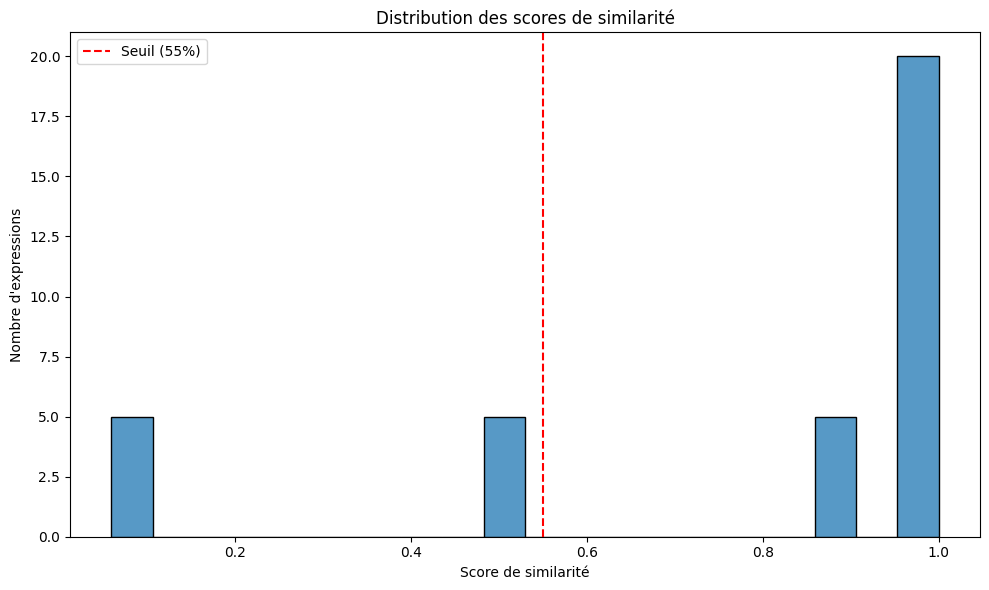

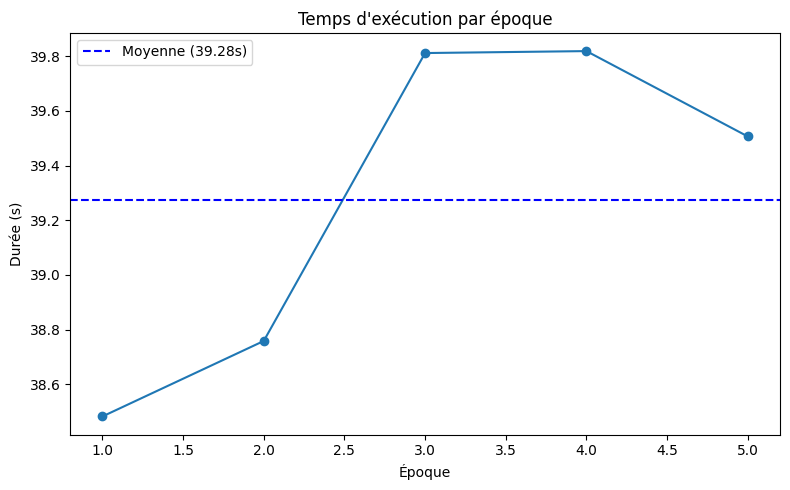

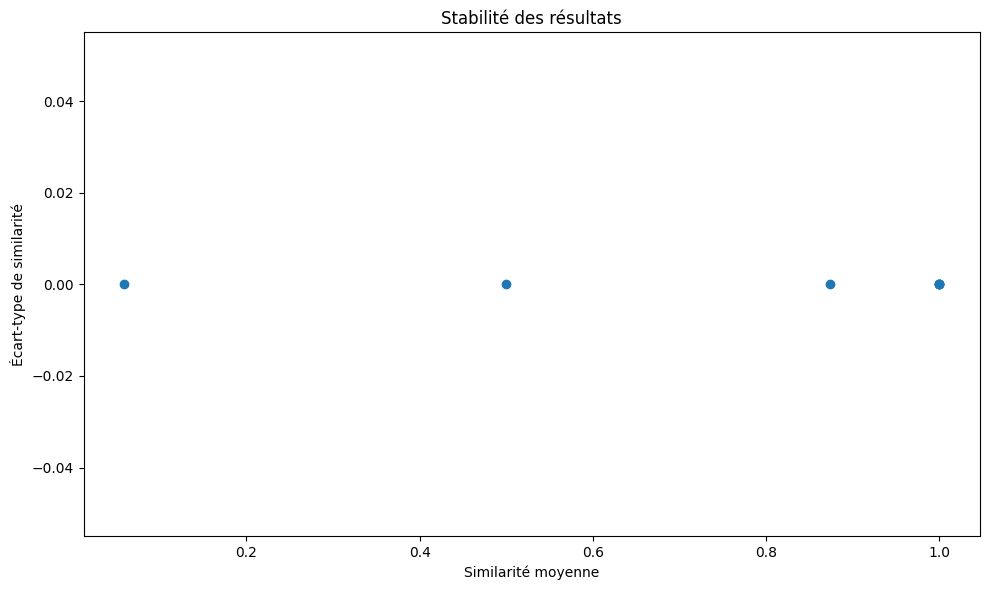

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import time
import json

TEST_RESULTS_BASE_PATH = "testResults/"

def setup_test_environment():
    """Crée le répertoire de résultats s'il n'existe pas."""
    os.makedirs(TEST_RESULTS_BASE_PATH, exist_ok=True)

def calculate_similarity(expected, generated):
    """
    Calculate cosine similarity between expected and generated expressions.

    Args:
        expected (str): Expected Symfony expression.
        generated (str): Generated Symfony expression.

    Returns:
        float: Cosine similarity score.
    """
    # Vérifier d'abord si les expressions sont strictement identiques
    if expected == generated:
        return 1.0

    # Si les expressions diffèrent seulement par des espaces/tabulations
    if expected.strip() == generated.strip():
        return 1.0

    # Sinon, calculer la similarité par embedding
    expected_embedding = get_embedding(expected)
    generated_embedding = get_embedding(generated)

    # Vérifier que les embeddings ne sont pas des vecteurs nuls
    if not expected_embedding.any() or not generated_embedding.any():
        # Fallback: Utiliser une similarité basée sur les mots communs
        expected_words = set(expected.split())
        generated_words = set(generated.split())

        if not expected_words:
            return 0.0

        common_words = expected_words.intersection(generated_words)
        return len(common_words) / len(expected_words)

    # Calculer la similarité cosinus
    return float(cosine_similarity([expected_embedding], [generated_embedding])[0][0])

def process_single_test(test, available_context, examples, similarity_threshold):
    """
    Traite un cas de test unique.

    Args:
        test (dict): Dictionnaire contenant 'query' et 'expected'
        available_context (dict): Contexte pour generate_expression
        examples (dict): Exemples pour generate_expression
        similarity_threshold (float): Seuil de similarité

    Returns:
        dict: Résultat du test avec métriques
    """
    # Mesure du temps d'exécution
    start_time = time.time()
    generated = generate_expression(test['query'], available_context, examples)
    execution_time = time.time() - start_time

    # Cas d'erreur
    if generated == "Une erreur est survenue, veuillez réessayer.":
        return {
            'query': test['query'],
            'expected': test['expected'],
            'generated': generated,
            'similarity': 0.0,
            'is_match': False,
            'execution_time': execution_time,
            'error': True
        }

    # Calcul de similarité et correspondance
    similarity = calculate_similarity(test['expected'], generated)
    exact_match = generated == test['expected']  # Correspondance exacte
    similarity_match = similarity >= similarity_threshold  # Correspondance par similarité

    # Mesure de correspondance de mots-clés
    expected_words = set(test['expected'].split())
    generated_words = set(generated.split())
    common_words = expected_words.intersection(generated_words)
    keyword_coverage = len(common_words) / len(expected_words) if expected_words else 0

    return {
        'query': test['query'],
        'expected': test['expected'],
        'generated': generated,
        'similarity': similarity,
        'exact_match': exact_match,
        'similarity_match': similarity_match,
        'is_match': exact_match or similarity_match,  # Match global
        'execution_time': execution_time,
        'keyword_coverage': keyword_coverage,
        'error': False
    }

def aggregate_test_results(all_test_results, test_cases, K):
    """Agrège les résultats de tous les tests sur toutes les époques."""

    # Créer un DataFrame avec tous les résultats
    all_results_df = pd.DataFrame(all_test_results)

    # Structure pour stocker les résultats agrégés par requête
    aggregated_results = []

    # Grouper par requête pour calculer les moyennes
    for query in set(all_results_df['query']):
        query_results = all_results_df[all_results_df['query'] == query]

        # Trouver la meilleure génération (celle avec la similarité la plus élevée)
        if not query_results[~query_results['error']].empty:
            best_result = query_results.loc[query_results['similarity'].idxmax()]
        else:
            # Si toutes les générations ont échoué
            best_result = query_results.iloc[0]

        # Calculer les statistiques
        avg_result = {
            'query': query,
            'expected': best_result['expected'],
            'best_generated': best_result['generated'],
            'avg_similarity': query_results['similarity'].mean(),
            'max_similarity': query_results['similarity'].max(),
            'min_similarity': query_results['similarity'].min(),
            'std_similarity': query_results['similarity'].std(),
            'exact_match_rate': query_results['exact_match'].mean(),
            'similarity_match_rate': query_results['similarity_match'].mean(),
            'match_rate': query_results['is_match'].mean(),
            'avg_execution_time': query_results['execution_time'].mean(),
            'error_rate': query_results['error'].mean(),
            'avg_keyword_coverage': query_results['keyword_coverage'].mean() if 'keyword_coverage' in query_results else 0,
            'runs': len(query_results),
            'success_rate': len(query_results[~query_results['error']]) / len(query_results)
        }
        aggregated_results.append(avg_result)

    return pd.DataFrame(aggregated_results)

def run_tests(available_context, symfony_examples, similarity_threshold=0.55, K=5, fast_mode=False):
    """
    Exécute le processus de test complet.

    Args:
        available_context (dict): Contexte pour generate_expression
        symfony_examples (dict): Exemples pour generate_expression
        similarity_threshold (float): Seuil de similarité
        K (int): Nombre d'époques à exécuter
        fast_mode (bool): Si True, n'exécute qu'une époque et saute les graphiques

    Returns:
        DataFrame: Résultats agrégés
    """
    setup_test_environment()

    # En mode rapide, exécuter une seule époque
    if fast_mode:
        K = 1

    all_test_results = []
    epoch_times = []
    start_total = time.time()

    # Itération sur chaque époque
    for epoch in range(1, K + 1):
        print(f"Exécution de l'époque {epoch}/{K}...")
        start_epoch = time.time()

        epoch_results = []
        with open(TEST_RESULTS_BASE_PATH + f"detailed_results_epoch_{epoch}.txt", "w", encoding="utf-8") as f:
            f.write(f"=== RÉSULTATS DÉTAILLÉS - ÉPOQUE {epoch}/{K} ===\n\n")

            # Traiter chaque cas de test
            for test in test_cases:
                result = process_single_test(test, available_context, symfony_examples, similarity_threshold)
                epoch_results.append(result)
                all_test_results.append({**result, 'epoch': epoch})

                # Écrire les détails du test
                f.write(f"Query: {result['query']}\n")
                f.write(f"Expected: {result['expected']}\n")
                f.write(f"Generated: {result['generated']}\n")
                f.write(f"Similarité: {result['similarity']:.2%}\n")
                f.write(f"Temps: {result['execution_time']:.3f}s\n")
                if 'keyword_coverage' in result:
                    f.write(f"Couverture mots-clés: {result['keyword_coverage']:.2%}\n")
                f.write(f"Status: {'❌ Erreur' if result.get('error', False) else ('✅ Match' if result['is_match'] else '❌ No Match')}\n\n")

        # Calculer et enregistrer le temps d'époque
        duration = time.time() - start_epoch
        epoch_times.append(duration)

        # Créer un DataFrame pour cette époque
        epoch_df = pd.DataFrame(epoch_results)

        # Analyser et afficher les statistiques d'époque
        if not epoch_df.empty:
            epoch_df.to_csv(TEST_RESULTS_BASE_PATH + f'results_epoch_{epoch}.csv', index=False)
            error_count = epoch_df['error'].sum() if 'error' in epoch_df else 0
            match_count = epoch_df['is_match'].sum()
            print(f"Match: {match_count}/{len(epoch_df)} ({match_count/len(epoch_df):.2%})")
            print(f"Erreurs: {error_count}/{len(epoch_df)} ({error_count/len(epoch_df):.2%})")
        else:
            print("Tous les tests ont échoué!")

        print(f"Époque {epoch} terminée en {duration:.2f} secondes.\n")

    # Calculer et afficher le temps total
    total_time = time.time() - start_total
    print(f"Temps total d'exécution: {total_time:.2f}s")

    # Agréger tous les résultats
    aggregated_df = aggregate_test_results(all_test_results, test_cases, K)

    # Sauvegarder les résultats agrégés
    aggregated_df.to_csv(TEST_RESULTS_BASE_PATH + 'aggregated_results.csv', index=False)

    # Créer un rapport de synthèse
    with open(TEST_RESULTS_BASE_PATH + "summary.txt", "w", encoding="utf-8") as f:
        f.write("=== SYNTHÈSE DES TESTS D'EXPRESSIONS SYMFONY ===\n\n")
        f.write(f"Nombre total de cas de test: {len(test_cases)}\n")
        f.write(f"Nombre d'époques: {K}\n")
        f.write(f"Temps d'exécution total: {total_time:.2f}s\n")
        f.write(f"Temps moyen par époque: {np.mean(epoch_times):.2f}s\n\n")

        f.write("--- Métriques globales ---\n")
        f.write(f"Taux de correspondance exacte: {aggregated_df['exact_match_rate'].mean():.2%}\n")
        f.write(f"Taux de correspondance par similarité: {aggregated_df['similarity_match_rate'].mean():.2%}\n")
        f.write(f"Taux de correspondance global: {aggregated_df['match_rate'].mean():.2%}\n")
        f.write(f"Taux d'erreur: {aggregated_df['error_rate'].mean():.2%}\n")
        f.write(f"Similarité moyenne: {aggregated_df['avg_similarity'].mean():.2%}\n")
        if 'avg_keyword_coverage' in aggregated_df:
            f.write(f"Couverture moyenne de mots-clés: {aggregated_df['avg_keyword_coverage'].mean():.2%}\n")

        # Top 3 des meilleurs résultats
        f.write("\n--- TOP 3 des meilleurs résultats ---\n")
        top_results = aggregated_df.sort_values('max_similarity', ascending=False).head(3)
        for idx, row in top_results.iterrows():
            f.write(f"Query: {row['query']}\n")
            f.write(f"Expected: {row['expected']}\n")
            f.write(f"Generated: {row['best_generated']}\n")
            f.write(f"Similarité max: {row['max_similarity']:.2%}\n\n")

        # Top 3 des pires résultats
        f.write("\n--- TOP 3 des résultats les moins bons ---\n")
        bottom_results = aggregated_df.sort_values('max_similarity').head(3)
        for idx, row in bottom_results.iterrows():
            f.write(f"Query: {row['query']}\n")
            f.write(f"Expected: {row['expected']}\n")
            f.write(f"Generated: {row['best_generated']}\n")
            f.write(f"Similarité max: {row['max_similarity']:.2%}\n\n")

    # Créer des visualisations si nous ne sommes pas en mode rapide
    if not fast_mode:
        all_results_df = pd.DataFrame(all_test_results)

        # Distribution des similarités
        plt.figure(figsize=(10, 6))
        sns.histplot(data=all_results_df, x='similarity', bins=20)
        plt.axvline(x=similarity_threshold, color='red', linestyle='--',
                    label=f'Seuil ({similarity_threshold:.0%})')
        plt.title('Distribution des scores de similarité')
        plt.xlabel('Score de similarité')
        plt.ylabel("Nombre d'expressions")
        plt.legend()
        plt.tight_layout()
        plt.savefig(TEST_RESULTS_BASE_PATH + 'distribution_similarite.png')

        # Graphique des temps d'exécution
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(epoch_times)+1), epoch_times, marker='o')
        plt.axhline(np.mean(epoch_times), color='blue', linestyle='--',
                    label=f'Moyenne ({np.mean(epoch_times):.2f}s)')
        plt.title('Temps d\'exécution par époque')
        plt.xlabel('Époque')
        plt.ylabel('Durée (s)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(TEST_RESULTS_BASE_PATH + 'epoch_times.png')

        # Graphique de stabilité (similarité vs écart-type)
        plt.figure(figsize=(10, 6))
        plt.scatter(aggregated_df['avg_similarity'], aggregated_df['std_similarity'])
        plt.title('Stabilité des résultats')
        plt.xlabel('Similarité moyenne')
        plt.ylabel('Écart-type de similarité')
        plt.tight_layout()
        plt.savefig(TEST_RESULTS_BASE_PATH + 'stabilite.png')

    print(f"Taux de correspondance global: {aggregated_df['match_rate'].mean():.2%}")
    print(f"Similarité moyenne: {aggregated_df['avg_similarity'].mean():.2%}")
    print(f"Résultats détaillés disponibles dans le dossier: {TEST_RESULTS_BASE_PATH}")

    return aggregated_df

test_cases = read_file('test_data/test_cases.json')
run_tests(AVAILABLE_CONTEXT, SYMFONY_EXAMPLES, K=5)